# Testing Images Optimal Transport Benchmarks (unequal dims)
Evaluation of the OTM algorithm in the **unequal dimensions** benchmark based on the "Early" [Continuous Wasserstein-2 Benchmark](https://github.com/iamalexkorotin/Wasserstein2Benchmark) for images.

**WARNING!** This notebook should be tested inside ```Wasserstein2Benchmark/notebooks``` folder! 

**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

from src.tools import unfreeze, freeze
from src.resnet2 import ResNet_G, weights_init_G, ResNet_D
from src.icnn import View
from torch import nn
import src.map_benchmark as mbm

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
BATCH_SIZE = 64
GPU_DEVICE = 0

K_G = 10
K_psi = 1

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000001); np.random.seed(0x000001)

## Benchmark Loading

In [3]:
benchmark = mbm.CelebA64Benchmark(which='Early', batch_size=BATCH_SIZE)

# Initializing the ground truth map G* and embedding Q
G_star = benchmark.input_sampler.base_sampler.pushforward # Ground truth OT map
Q = lambda X: benchmark.output_sampler.potential.push(G_star(X)).detach() # Embedding Q

X_sampler = benchmark.input_sampler.base_sampler.base_sampler
Y_sampler = benchmark.input_sampler

## Code for plotting

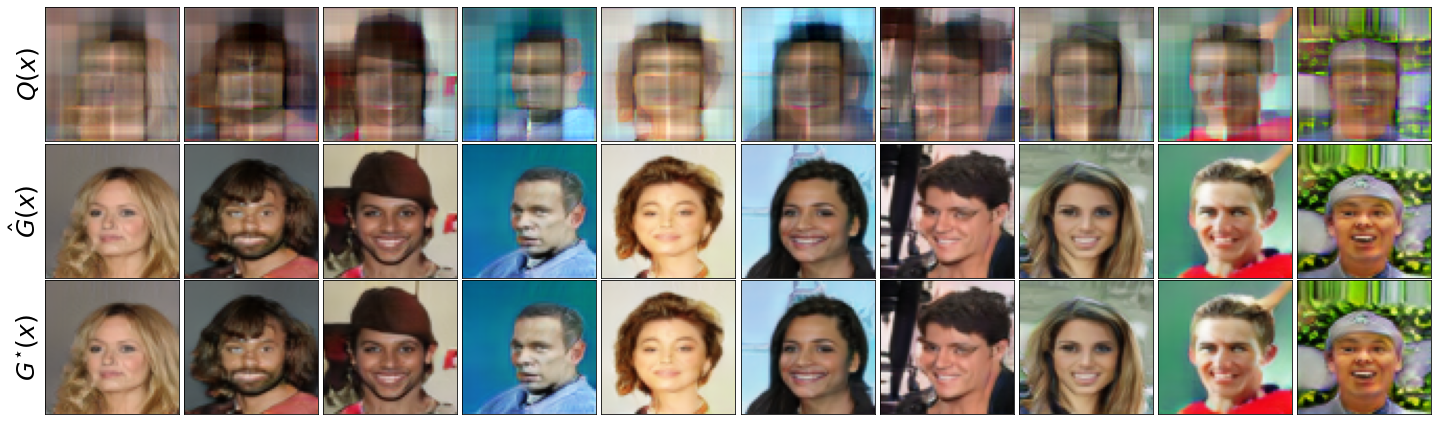

In [4]:
Z = torch.randn(10, 128, device='cuda', requires_grad=True)

def plot(Z, Q, G, G_star):
    fig, axes = plt.subplots(3, len(Z), figsize=(len(Z)*2+.1, 3*2))
    Q_Z = Q(Z).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    G_Z = G(Z).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    G_star_Z = G_star(Z).reshape(-1, 3, 64, 64).mul(.5).add(.5).clip(0, 1).cpu().detach()
    for i in range(len(Z)):
        axes[0,i].imshow(Q_Z[i].permute(1, 2, 0))
        axes[1,i].imshow(G_Z[i].permute(1, 2, 0))
        axes[2,i].imshow(G_star_Z[i].permute(1, 2, 0))
        
    for i, ax in enumerate(axes.flatten()):
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel(r'$Q(x)$', fontsize=25)
    axes[1, 0].set_ylabel(r'$\hat{G}(x)$', fontsize=25)
    axes[2, 0].set_ylabel(r'$G^{\star}(x)$', fontsize=25)
    
    fig.tight_layout(h_pad=0.01, w_pad=0.01)
    gc.collect(); torch.cuda.empty_cache()
    return fig, axes

# Test plot with G=G_star (the 2nd line matches the 3rd)
fig, axes = plot(Z, Q, G_star, G_star) 

## Initializing networks

In [5]:
# Generator
G = nn.Sequential(
    ResNet_G(128, 64, nfilter=64, nfilter_max=512, res_ratio=0.1),
    View(64*64*3)
)
G.apply(weights_init_G)
G = G.cuda()

In [6]:
# Potential
psi = nn.Sequential(
    View(3, 64, 64),
    ResNet_D(),
)

def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

psi.apply(weights_init_D)
psi = psi.cuda()

## Training Loss

In [7]:
def QW2Loss(psi,G,Q,X,Y):
    G_X = G(X)
    X.requires_grad_(True) # Needed for the benchmark to work
    return (Q(X).detach() * G_X).mean(dim=1).mean() - psi(G_X).mean() + psi(Y).mean()

#     Note: .mean(dim=1) can be replaced by .sum(dim=1)

## Main Training

In [8]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-10)
psi_opt = torch.optim.Adam(psi.parameters(), lr=1e-4, weight_decay=1e-10)

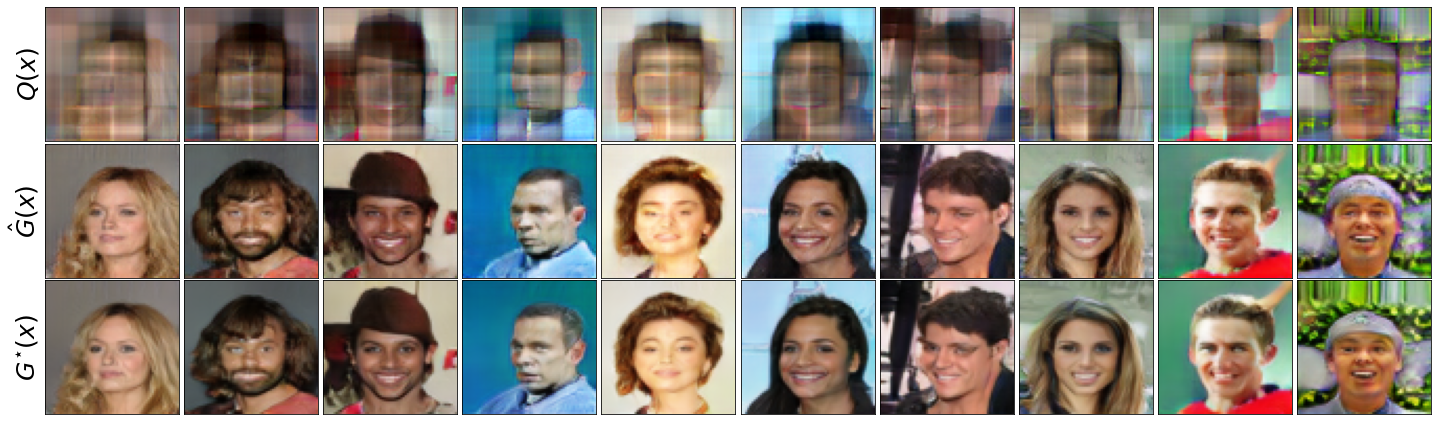

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [32:29:16<00:00,  4.68s/it]


In [9]:
for it in tqdm(range(25000)):
    ##########################################################
    ## Outer minimization loop
    ##########################################################   
    freeze(G); unfreeze(psi)
    for k_psi in range(K_psi):
        X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        psi_loss = QW2Loss(psi, G, Q, X, Y)
        psi_opt.zero_grad(); psi_loss.backward(); psi_opt.step()
    del psi_loss
    gc.collect(); torch.cuda.empty_cache()

    ##########################################################
    ## Inner maximization loop
    ##########################################################
    freeze(psi); unfreeze(G)
    for k_G in range(K_G):
        X, Y = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        G_loss = -QW2Loss(psi, G, Q, X, Y) 
        G_opt.zero_grad(); G_loss.backward(); G_opt.step()
    del G_loss
    gc.collect(); torch.cuda.empty_cache()
        
    if it % 50 == 0:
        clear_output(wait=True); freeze(G)
        fig, axes = plot(Z, Q, G, G_star); plt.show()

In [10]:
freeze(G)
L2s = []
for batch_idx in tqdm(range(2**14 // 64)):
    X = X_sampler.sample(BATCH_SIZE)
    G_star_X = G_star(X).detach()
    G_X = G(X).detach()
    L2s.append(((G_star_X-G_X) ** 2).sum(dim=1).mean().item())
    
print('L2-UVP =', 100 * np.mean(L2s) / Y_sampler.var)

100%|███████████████████████████████████████████████████████████████████████████████████| 256/256 [00:19<00:00, 12.95it/s]

L2-UVP = 9.505331340167123
